- Related [topcoder](https://community.topcoder.com/longcontest/?module=ViewProblemStatement&rd=17036&pm=14735) competition

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from __future__ import print_function 
from __future__ import division
# from __future__ import unicode_literals
# from future.utils import raise_with_traceback

In [109]:
import os,sys
import re
import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from pathlib import Path
import pdb

# osmnx library
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__


# outputting helpers
from output_helpers import * 

# preprocess helpers by CosmiQ
import apls, apls_tools, create_spacenet_masks, graphTools

In [ ]:
this_nb_path = os.getcwd()
print("this nb path: ", this_nb_path)
if this_nb_path not in sys.path:
    sys.path.insert(0, this_nb_path)
sys.path

In [77]:
rt2idx, idx2rt = rt2idx_and_idx2rt()
print(rt2idx)

{'unclassifed': 5, 'Residential': 4, 'primary': 1, 'cart': 6, 'motorway': 0, 'tertiary': 3, 'secondary': 2}


## Load data path

Here is the structure of the spacenet dataset folder

In [34]:
print_tree(data_dir, max_nfiles=1)

/
AOI_5_Khartoum_Roads_Sample/
    summaryData/
        AOI_5_Khartoum_Roads_Sample.csv
    MUL/
        MUL_AOI_5_Khartoum_img74.tif
        ...9 more files
    RGB-PanSharpen/
        RGB-PanSharpen_AOI_5_Khartoum_img220.tif
        ...9 more files
    geojson/
        spacenetroads/
            spacenetroads_AOI_5_Khartoum_img74.geojson
            ...9 more files
    PAN/
        PAN_AOI_5_Khartoum_img157.tif
        ...9 more files
    MUL-PanSharpen/
        MUL-PanSharpen_AOI_5_Khartoum_img220.tif
        ...9 more files
AOI_4_Shanghai_Roads_Sample/
    summaryData/
        AOI_4_Shanghai_Roads_Sample.csv
    MUL/
        MUL_AOI_4_Shanghai_img1196.tif
        ...9 more files
    RGB-PanSharpen/
        RGB-PanSharpen_AOI_4_Shanghai_img1841.tif
        ...9 more files
    geojson/
        spacenetroads/
            spacenetroads_AOI_4_Shanghai_img1841.geojson
            ...9 more files
    PAN/
        PAN_AOI_4_Shanghai_img1916.tif
        ...9 more files
    MUL-PanSharpen/
 

In [35]:
def get_imgId(img_path):
    """
    Extract img ID from the path to the img file. 
    For example, if a path is /home/hayley/Data/Vector/spacenetroads_AOI_2_Vegas_img1323.geojson
    this function returns 1323
    
    Args:
    - img_path (str or pathlib.Path): str or path object to the file
    Returns:
    - int for the image ID
    """
    if isinstance(img_path, Path):
        img_path = str(img_path)
        
    fname = img_path.split('_')[-1]
    return int(re.findall(r'\d+', fname)[0])


In [36]:
vegas_root = Path("/home/hayley/Data_Spacenet/SpaceNet_Roads_Sample/AOI_2_Vegas_Roads_Sample/")
vegas_rgb = vegas_root/"RGB-PanSharpen"
vegas_vector = vegas_root/"geojson/spacenetroads"

k_root = Path("/home/hayley/Data_Spacenet/SpaceNet_Roads_Sample/AOI_5_Khartoum_Roads_Sample/")
k_rgb = k_root/"RGB-PanSharpen"
k_vector = k_root/"geojson/spacenetroads"

In [37]:
vegas_vector_fnames =  [str(x) for x in vegas_vector.iterdir() if x.is_file() and x.suffix == '.geojson']
vegas_rgb_fnames = [str(x) for x in vegas_rgb.iterdir() if x.is_file() and x.suffix == '.tif']
# Sort them to have correct matching pairs
vegas_vector_fnames = sorted(vegas_vector_fnames, key=lambda x: get_imgId(x))
vegas_rgb_fnames = sorted(vegas_rgb_fnames, key=lambda x: get_imgId(x))

k_vector_fnames = [str(x) for x in k_vector.iterdir() if x.is_file() and x.suffix == '.geojson']
k_rgb_fnames = [str(x) for x in k_rgb.iterdir() if x.is_file() and x.suffix == '.tif']
k_vector_fnames = sorted(k_vector_fnames, key=lambda x: get_imgId(x))
k_rgb_fnames = sorted(k_rgb_fnames, key=lambda x: get_imgId(x))

print("number of vector files:", len(vegas_vector_fnames))
print("number of rgb files:", len(vegas_rgb_fnames))

print("number of vector files:", len(k_vector_fnames))
print("number of rgb files:", len(k_rgb_fnames))

number of vector files: 10
number of rgb files: 10
number of vector files: 10
number of rgb files: 10


In [38]:
# reload(apls_tools)
apls_tools.convert_to_8Bit(str(k_rgb_fnames[0]), './temp.tif')

In [39]:
import cv2
img = cv2.imread('temp.tif', -1)
img.dtype

dtype('uint8')

In [40]:
img.shape

(1300, 1300, 3)

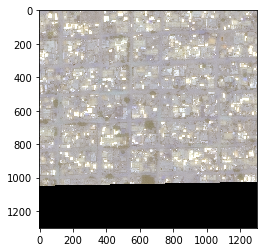

In [49]:
plt.imshow(img)

In [42]:
img16 = cv2.imread(str(k_rgb_fnames[0]),-1)
img16.dtype == 'uint16'

True

In [44]:
def show_in_8bits(fnames, axes=None, ncols=3, figsize=(20,20), verbose=False):
    """
    show raster image in 8 bits. It silently performs 16->8bit conversion 
    if the input is 16 bits by calling `convert_to_8bits` in apls_tools.py
    """
    if not isinstance(fnames, list):
        raise ValueError("input must be a list")
        
    from math import ceil
    nrows = max(1, int(ceil(len(fnames)/ncols)))
    if axes is None: f,axes = plt.subplots(nrows,ncols,figsize=figsize)
    axes = axes.flatten()
    
    for i,fname in enumerate(fnames):
        img = cv2.imread(fname,-1)

        if img.dtype == 'uint16':
            if verbose:
                print("{} is 16bits. We'll convert it to 8bits".format(fname))
            out_name = './temp_{}.tif'.format(i)
            apls_tools.convert_to_8Bit(fname, out_name)
            img = cv2.imread(out_name,-1)
        assert(img.dtype != 'uint16')

        axes[i].imshow(img)
        axes[i].set_title("_".join(fname.split('_')[-2:]))
    
    # Delete any empty axes
    for j in range(len(fnames),len(axes)): 
        f.delaxes(axes[j])

    return f,axes[:len(fnames)]

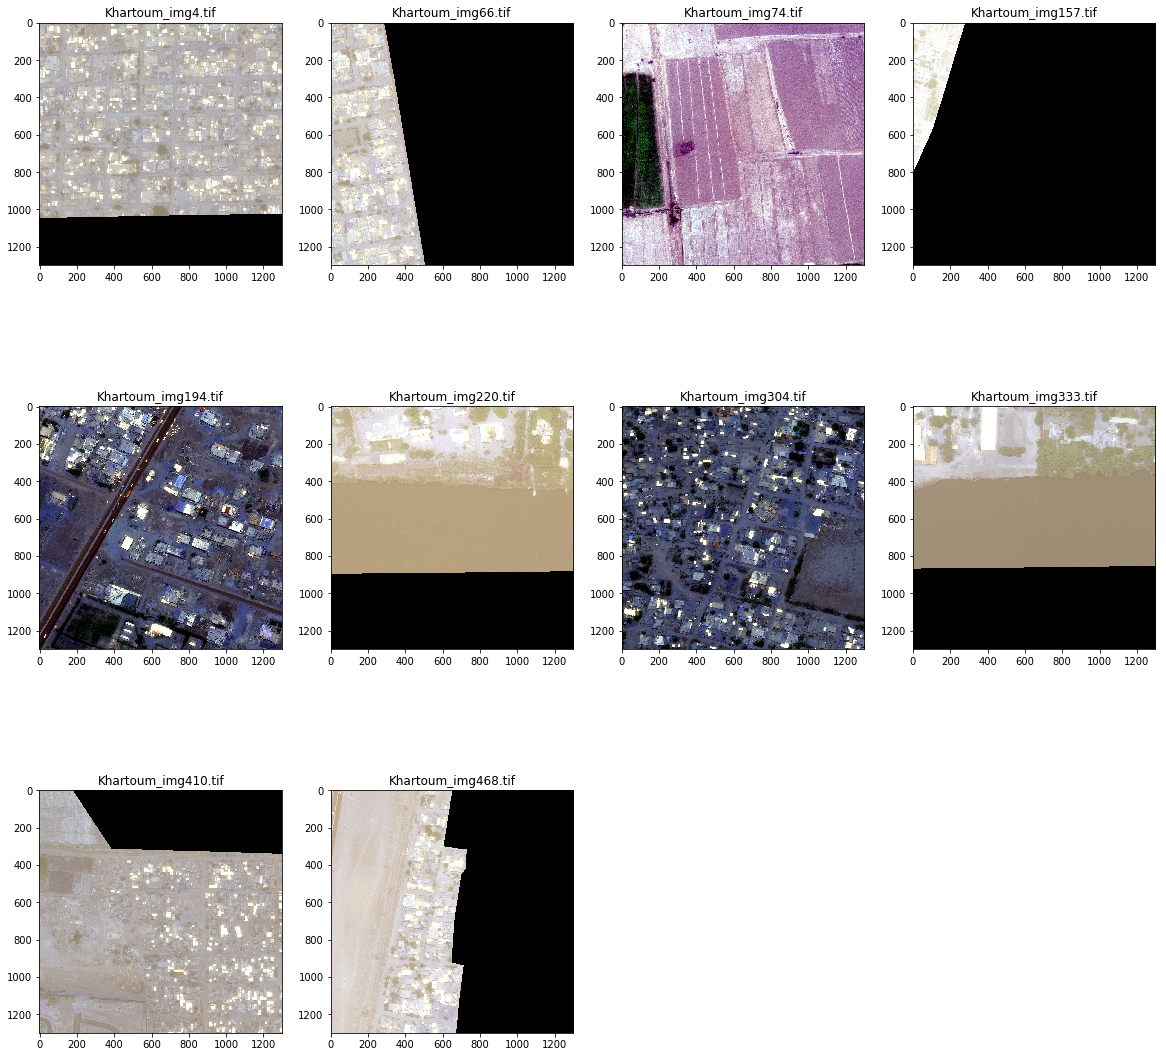

In [45]:
show_in_8bits(k_rgb_fnames, ncols=4);

## Create road mask

In [78]:
f = gpd.read_file(vegas_vector_fnames[1])

In [82]:
print(vegas_vector_fnames[1].split('/')[-1])
print(len(f))
print(f['road_type'].unique())

spacenetroads_AOI_2_Vegas_img408.geojson
38
[u'5' u'3' u'6']


In [61]:
# f.columns
roadset = gpd.read_file(vegas_vector_fnames[1])
print(len(roadset))
roadset2 = roadset.iloc[:3, :]

38


In [66]:
roadset.to_file('~/big.geojson', driver='GeoJSON')

In [68]:
def gdf2geojson(gdf, out_name):
    gdf.to_file(out_name, driver='GeoJSON')

In [69]:
gdf2geojson(roadset.copy(), 'big2.geojson')

In [60]:
roadset2.to_file('~/temp.geojson', driver='GeoJSON')
def get_width(gdf,
             rt_col="road_type",
             ln_col="lane_number"):
    """
    Computes the width of a road (each row) based on the "road_type" and "lane_number" values
    Args:
    - gdf (geopandas.DataFrame): must have "road_type" and "lane_number
    - rt_col (str): column name for the road type
    - ln_col (str): column name for the number of lanes
    
    Returns:
    - widths (geopands.DataFrame): same length as gdf, each row encodes the width of the correpsonding row of gdf
    """
    widths = gdf[rt_col] gdf[ln_col]

## OSMNX library introduction

In [102]:
gpd_road = gpd.read_file(vegas_vector_fnames[1])


In [ ]:
city = ox.gdf_from_place("Berkeley, California")
ox.project_gdf(

In [ ]:
g = geo[0]

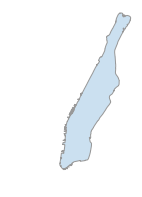

In [47]:
# get the boundary polygon for manhattan, save it as a shapefile, project it to UTM, and plot it
city = ox.gdf_from_place('Manhattan Island, New York, New York, USA')
ox.save_gdf_shapefile(city)
city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(3,3))

In [48]:
# loc = (15.6030862, 32.5262226)
loc = (15.5190322, 32.494794) #kHARTOUM IMG8 center coordinate

g = ox.graph_from_point(loc, distance=200, distance_type='bbox', network_type='all_private')
g = ox.project_graph(g)

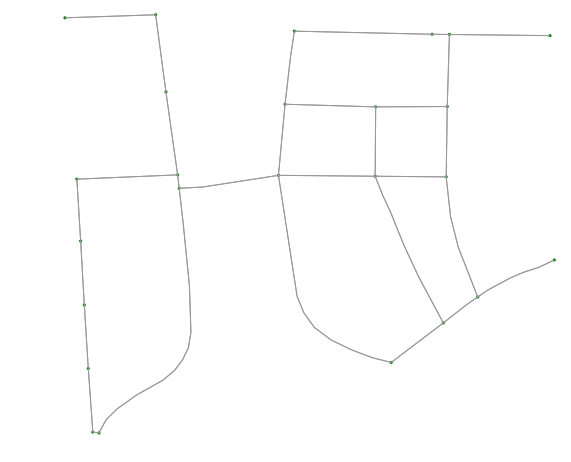

In [46]:
fig, ax = ox.plot_graph(g, node_size=10, node_color='g', fig_height=8)

In [84]:
# Get a networkx graph object from given address within the distnace
## The returned object's crs is lat-lon (ie, unprojected)
g = ox.graph_from_address('424 w. pico blvd, Los Angeles, CA',
                           distance = 500, distance_type='network', 
                           network_type='walk')

In [86]:
## If we keep using crs=lat-lon:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(g)
gdf_nodes.crs
#epsg:4326 is longlat


{'init': 'epsg:4326'}

In [89]:
gdf_edges.highway.unique()

array([u'residential', u'primary', u'secondary', u'service'], dtype=object)

In [94]:
g.graph['crs'] #original (unprojected) crs: epsg:4236, aka. lat-lon crs

{'init': 'epsg:4326'}

In [92]:
g_projected = ox.project_graph(g) #project latlon to utm (default)

In [95]:
print(g_projected.graph['crs'])

{'units': 'm', 'ellps': 'GRS80', 'datum': 'NAD83', 'proj': 'utm', 'zone': 11}


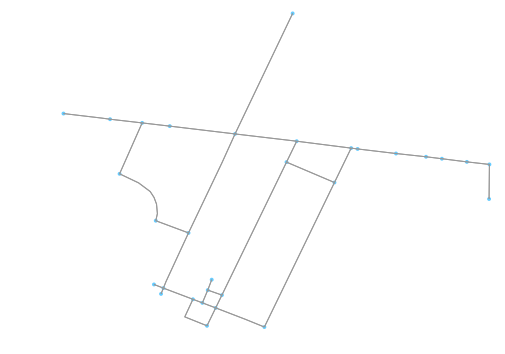

(<Figure size 571.59x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6254399cd0>)

In [98]:
ox.plot_graph(g_projected)

In [230]:
gdf = ox.graph_to_gdfs(g_projected)
g_projected['buffer'] = g_projected.buffer(2)
fig, ax = ox.plot_graph(g2_projected, node_size=30)

AttributeError: 'MultiDiGraph' object has no attribute 'buffer'

In [102]:
nc = ['r' if 'highway' in d else 'b' for n,d in g2.nodes(data=True)]

In [122]:
print(g2.edges(data=True)[:3])

[(1842523671, 123273663, {'lanes': u'2', 'name': u'5th Avenue', 'length': 71.94364640397427, 'oneway': False, 'highway': u'residential', 'osmid': 165524382}), (123017356, 123017328, {'lanes': u'4', 'name': u'West Pico Boulevard', 'length': 56.115353379720155, 'oneway': False, 'highway': u'primary', 'osmid': 398222698}), (123017356, 123017358, {'length': 115.33904865937451, 'oneway': False, 'name': u'South Windsor Boulevard', 'highway': u'residential', 'osmid': 13355759})]


In [120]:
# ox.plot_graph(g2_projected, node_size=30, node_color=nc, );

In [116]:
temp

In [132]:
gdf_n, gdf_e = gdf2
print("gdf_n coloumns:", sorted(list(gdf_n.columns)))
print("gdf_e coloumns:", sorted(list(gdf_e.columns)))
gdf_n[:5]

gdf_n coloumns: ['geometry', 'highway', 'osmid', 'x', 'y']
gdf_e coloumns: ['geometry', 'highway', 'key', 'lanes', 'length', 'name', 'oneway', 'osmid', 'u', 'v']


In [160]:
# gdf_n.set_index('osmid', inplace=True)
# gdf_e.set_index('osmid', inplace=True)

gdf_n[:5]

,highway,x,y,geometry
osmid,,,,
21748281,traffic_signals,-118.327,34.0478,POINT (-118.3267156 34.0478237)
60947745,traffic_signals,-118.328,34.0447,POINT (-118.3284409 34.0446852)
122594255,NaN,-118.325,34.0476,POINT (-118.324537 34.0476167)
122807243,NaN,-118.327,34.0502,POINT (-118.3268412 34.0502142)
123017328,NaN,-118.33,34.0481,POINT (-118.3295001 34.0480758)


In [162]:
gdf_e[:5]

,geometry,highway,key,lanes,length,name,oneway,u,v
osmid,,,,,,,,,
165524382,"LINESTRING (-118.3224853 34.0467876, -118.3224...",residential,0,2,71.943646,5th Avenue,False,1842523671,123273663
398222698,"LINESTRING (-118.3301057 34.0481296, -118.3295...",primary,0,4,56.115353,West Pico Boulevard,False,123017356,123017328
13355759,"LINESTRING (-118.3301057 34.0481296, -118.3305...",residential,0,NaN,115.339049,South Windsor Boulevard,False,123017356,123017358
398222698,"LINESTRING (-118.3301057 34.0481296, -118.3308...",primary,0,4,65.200256,West Pico Boulevard,False,123017356,123741062
13401181,"LINESTRING (-118.3305848 34.0471713, -118.3301...",residential,0,NaN,136.564093,Victoria Park Drive,False,123017358,123039316


## Color network edges according to the road type

In [181]:
road_types = gdf_e.highway.unique()
print(road_types)
rtype2idx = {rtype:i for i,rtype in enumerate(road_types)}
print(rtype2idx)
colors = np.array(['r','b','g','k','y'])
print(colors)

[u'residential' u'primary' u'secondary' u'service']
{u'residential': 0, u'primary': 1, u'service': 3, u'secondary': 2}
['r' 'b' 'g' 'k' 'y']


In [193]:
# color edges by road type
# for name, group in gdf_e.groupby('highway'):
#     print(name,len(group))
ec = [rtype2idx[r] for r in gdf_e['highway']]
ec = colors[ec]
gdf_e['road_type'] = ec

In [194]:
print(ec[:10])

['r' 'b' 'r' 'b' 'r' 'r' 'b' 'b' 'g' 'r']


In [184]:
print(gdf_e['geometry'][0])

LINESTRING (-118.3224853 34.0467876, -118.3224879 34.0474346)


In [186]:
gdf_n[gdf_n.index == 1842523671]

,highway,x,y,geometry
osmid,,,,


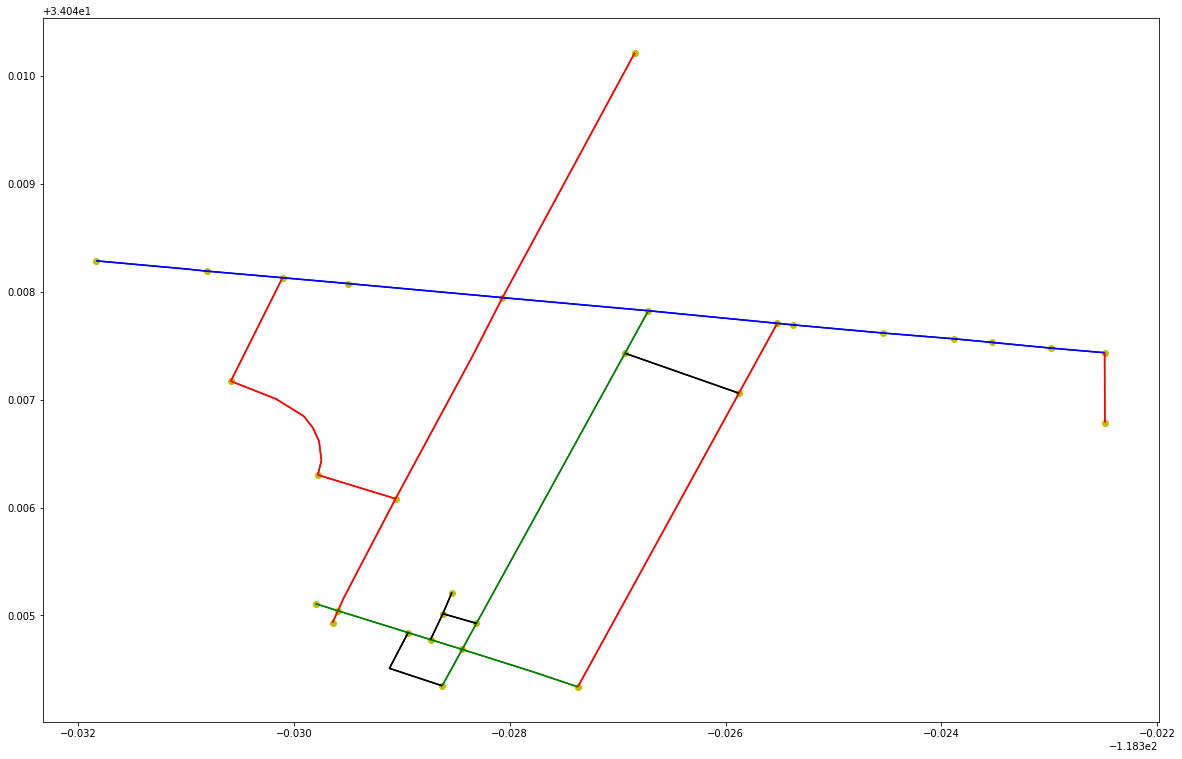

In [195]:
ax = gdf_e.plot(color=ec, figsize=(20,20))
gdf_n.plot(ax=ax, color='y')

In [323]:
def color_edge_by_type(G, ax=None, colors=None, figsize=(20,20)):
    """
    Args:
    - G (nx.graph or ox.graph) with nodes and edges
    Draw a graph network with nodes and edges with the edges colored by its road_type
    
    Returns:
    - ax (plt.Axes)
    """
    if ax is None:
        f,ax = plt.subplots(figsize=figsize)
        
    gdf_n, gdf_e = ox.graph_to_gdfs(G, nodes=True, edges=True)
    road_types = gdf_e.highway.unique()
    
    road2idx = {r:i for i,r in enumerate(road_types)}
    rindices = [road2idx[r] for r in gdf_e['highway']]
#     pdb.set_trace()
    gdf_e['road_type'] = rindices
    
    # colors
    if colors is None: 
        colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w') #todo: linspace and then map to cmap
    colors = np.array(colors)
    
    # Create color<->road_type textbar
    used_colors = [road2idx[r] for r in road_types]
    text = ''
    for i,r in enumerate(road_types):
        text += "".join([colors[road2idx[r]], ": ", r])
        if i < len(road_types)-1:
            text += '\n'
    print(text)
    gdf_e.plot(ax=ax,color=colors[rindices])
    gdf_n.plot(ax=ax,color='k')

#     ax.annotate(text, xy=(0.8, 0.8), xycoords='axes fraction')
    # Better to use Anchored textbook
    from matplotlib.offsetbox import AnchoredText
    
    textbox = AnchoredText(text, loc='upper right', prop=dict(size='x-large'),frameon=True)
    ax.add_artist(textbox)
    return ax

## Another way to set the colors (better since it is less hard-coded)
[reference](https://stackoverflow.com/a/38219022)
```python
...
colors = pl.cm.jet(np.linspace(0,1,n))
plt.plot(x,y,colors=colors)
```


b: residential
g: primary
r: secondary
c: service


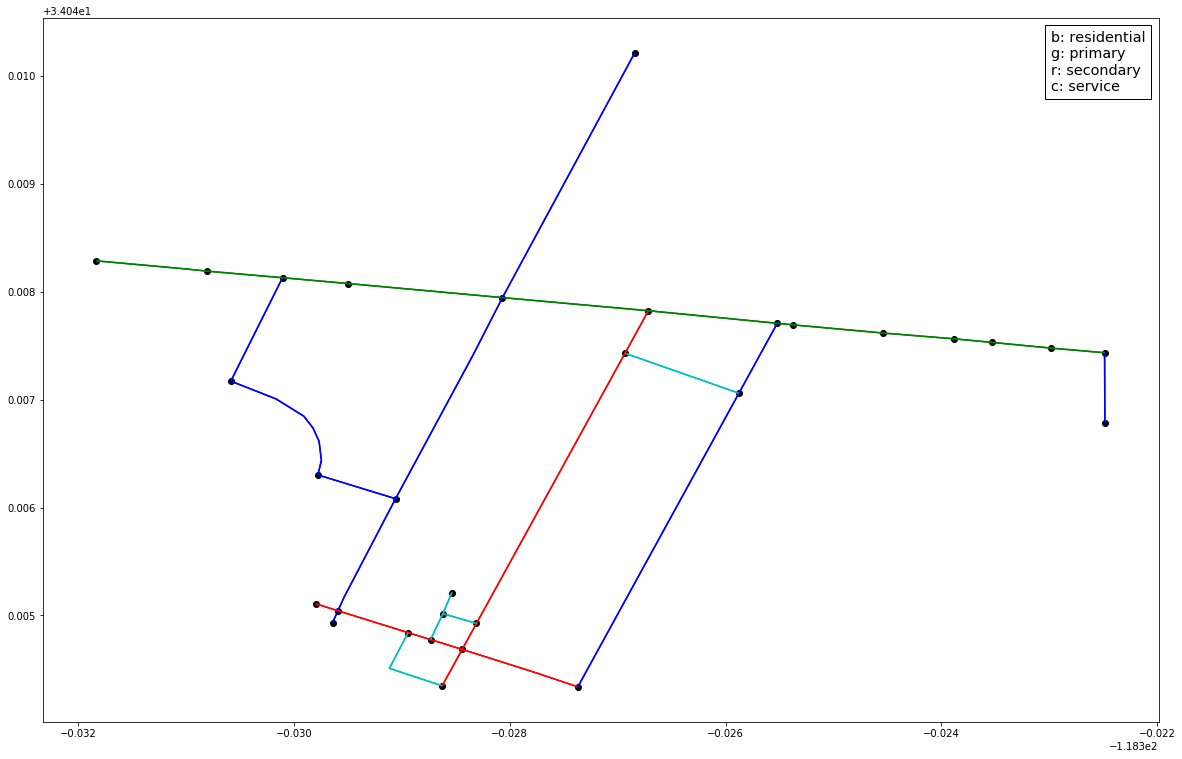

In [324]:
color_edge_by_type(g2);

## Create a buffer around a graph vector

In [202]:
gdf_e_small = gdf_e[:10].copy()

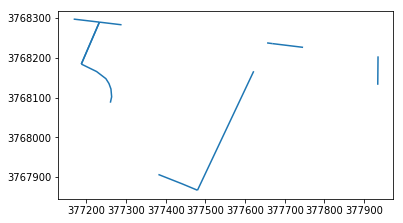

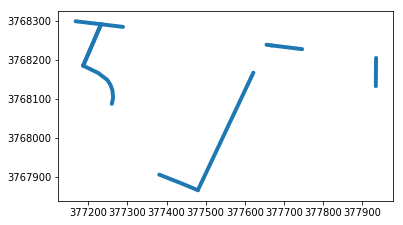

In [242]:
original = ox.project_gdf(gdf_e_small)
buffed = original.buffer(5)

original.plot()
buffed.plot()

Let's try to create a buffer with different widths depending on the road_type


In [244]:
gdf_e_small.head()

,geometry,highway,key,lanes,length,name,oneway,u,v,road_type
osmid,,,,,,,,,,
165524382,"LINESTRING (-118.3224853 34.0467876, -118.3224...",residential,0,2,71.943646,5th Avenue,False,1842523671,123273663,r
398222698,"LINESTRING (-118.3301057 34.0481296, -118.3295...",primary,0,4,56.115353,West Pico Boulevard,False,123017356,123017328,b
13355759,"LINESTRING (-118.3301057 34.0481296, -118.3305...",residential,0,NaN,115.339049,South Windsor Boulevard,False,123017356,123017358,r
398222698,"LINESTRING (-118.3301057 34.0481296, -118.3308...",primary,0,4,65.200256,West Pico Boulevard,False,123017356,123741062,b
13401181,"LINESTRING (-118.3305848 34.0471713, -118.3301...",residential,0,NaN,136.564093,Victoria Park Drive,False,123017358,123039316,r


In [256]:
gdf_sample = gdf_e_small.copy()
gdf_sample['geometry'] #Series object

osmid
165524382                            LINESTRING (-118.3224853 34.0467876, -118.3224...
398222698                            LINESTRING (-118.3301057 34.0481296, -118.3295...
13355759                             LINESTRING (-118.3301057 34.0481296, -118.3305...
398222698                            LINESTRING (-118.3301057 34.0481296, -118.3308...
13401181                             LINESTRING (-118.3305848 34.0471713, -118.3301...
13355759                             LINESTRING (-118.3305848 34.0471713, -118.3301...
398199843                            LINESTRING (-118.3253792 34.047693, -118.32552...
398199843                            LINESTRING (-118.3253792 34.047693, -118.32453...
[398222656, 398222654, 403725847]    LINESTRING (-118.3273691 34.0443386, -118.3275...
165560843                            LINESTRING (-118.3273691 34.0443386, -118.3258...
Name: geometry, dtype: object

In [ ]:
gdf_sample['buffed'] = gdf_sample['geometry'].buffer(1)
#Instead we want to create apply a buffer (input must be pd.Dataframe) 
#with the width as a function of the road-type (and number of lanes)

#check unique values in the column `highway` and `lanes`
print("highway vals: ", gdf_sample['highway'].unique())
print("lanes vals: \n", gdf_sample['lanes'].value_counts(dropna=False))
gdf_sample.head()
pd.Series.value_counts()

In [277]:
# Basic road-type vs. number of lanes analysis
## First let's try the osm data from the website using osmnx
## Based on Khartoum spacenet dataset
k_bbox = [[32.4, 15.5],
            [32.6, 15.7]]
k_center = (15.6331,32.5369) #flipped version of QGIS's coordinates
# k_center = (37.791427, -122.410018)
half = 500 #meter
k_graph = ox.graph_from_point(k_center, 
                              distance=500, 
                              distance_type='bbox',
                              network_type='all_private')

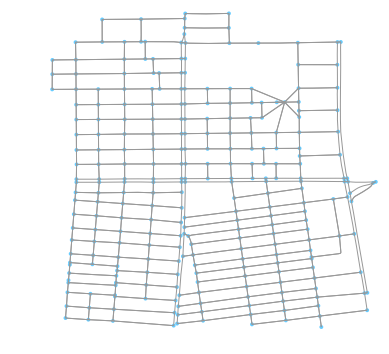

(<Figure size 434.275x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f30bf5281d0>)

In [281]:
ox.plot_graph(k_graph)

In [288]:
#nxgraph to geopandas DataFrame objects
k_gdf_n, k_gdf_e = ox.graph_to_gdfs(k_graph)
k_gdf_e['highway'].value_counts()

In [326]:
k_gdf_e.columns

Index([u'geometry', u'highway', u'key', u'length', u'name', u'oneway',
       u'osmid', u'u', u'v'],
      dtype='object')

In [288]:
for name, g in k_gdf_e.groupby('highway'):
    g.

residential     620
tertiary        143
unclassified     54
primary          17
service           2
primary_link      2
Name: highway, dtype: int64

b: residential
g: unclassified
r: tertiary
c: primary
m: primary_link
y: service


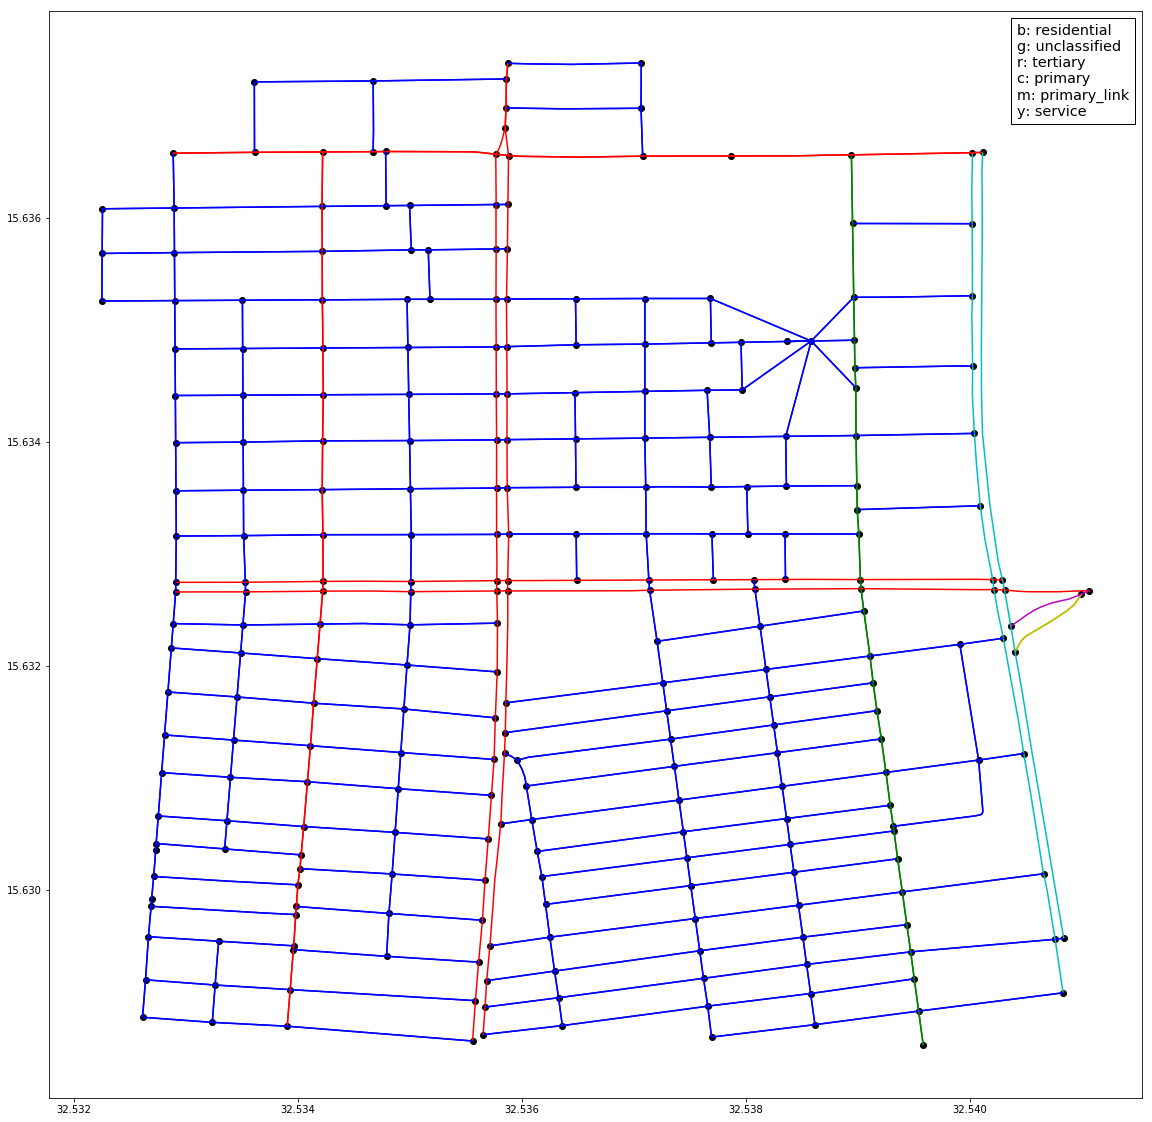

In [325]:
color_edge_by_type(k_graph)

### Geopandas DataFrame's CRS conversion
- gpd DataFrame object contains an attribute 'crs'
- this is set when the corresponding file is read (eg. in geojson, shapefile, etc the crs is specified).
- We can use ox.project_gdf(myGdf) to convert crs to UTM 
- Or, we can use geopandas's DataFrame.to_crs() 

[osmnx](http://bit.ly/2EMuL9k)
[geopandas: crs conversion](http://geopandas.org/projections.html)


In [211]:
original.crs

{'init': 'epsg:4326'}

In [214]:
ox.project_gdf(original).crs

{'datum': 'NAD83', 'ellps': 'GRS80', 'proj': 'utm', 'units': 'm', 'zone': 11}

{'units': 'm', 'ellps': 'GRS80', 'datum': 'NAD83', 'proj': 'utm', 'zone': 11}


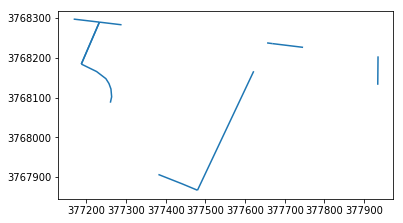

In [219]:
original.plot()
print(original.crs)

(<Figure size 1440x1440 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f30bdd4dd90>], dtype=object))

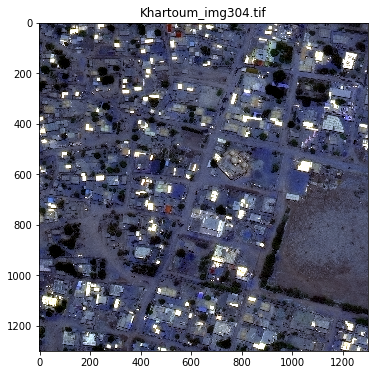

In [33]:
show_in_8bits([k_rgb_fnames[6]])

In [34]:
# Let's get a vector data and the mask plotted on this image
gdf = gpd.read_file(k_vector_fnames[6])

In [36]:
gdf.head()

,bridge_type,heading,lane_numbe,lane_number,one_way_type,paved,road_id,road_type,origarea,origlen,partialDec,truncated,geometry
0,2,0,2,2,2,2,13023,5,0,0.000820,1,0,"LINESTRING (32.555128897 15.730077578, 32.5552..."
1,2,0,2,2,2,2,11579,5,0,0.001056,1,0,"LINESTRING (32.555994091 15.730774351, 32.5560..."
2,2,0,2,2,2,2,6826,5,0,0.000768,1,0,"LINESTRING (32.555235216 15.730890506, 32.5559..."
3,2,0,2,2,2,2,8875,5,0,0.000596,1,0,"LINESTRING (32.554647607 15.730988874, 32.5552..."
4,2,0,1,1,2,2,4913,5,0,0.000459,1,0,"LINESTRING (32.555994091 15.730774351, 32.5560..."


In [39]:
gdf['type'] = gdf['road_type'].apply(lambda r: road2idx[
gdf['class'] = 'highway'
gdf['highway'] = 'highway'

In [69]:
gdf.apply(

'geometry'

In [75]:
gdf = gdf.rename(columns={'geometry':'roads'}).set_geometry('roads')

In [78]:
gdf.columns
gdf.geometry.name

'roads'

In [77]:
roads = gdf['roads']

In [54]:
bound_series = geom.bounds
bound_series[:5]

,minx,miny,maxx,maxy
0,32.555129,15.730078,32.555235,15.730891
1,32.555994,15.730768,32.556038,15.730774
2,32.555235,15.730774,32.555994,15.730891
3,32.554648,15.730891,32.555235,15.730989
4,32.555994,15.730774,32.556038,15.730992


In [57]:
bound_series.iloc[:,0:2].min()

minx    32.552528
miny    15.727921
dtype: float64

In [58]:
bound_series.iloc[:,2:].max()

maxx    32.556038
maxy    15.731431
dtype: float64

In [60]:
geom.total_bounds

array([ 32.5525284,  15.7279212,  32.5560384,  15.7314312])

In [79]:
gdf['centroid'] = roads.centroid

roads


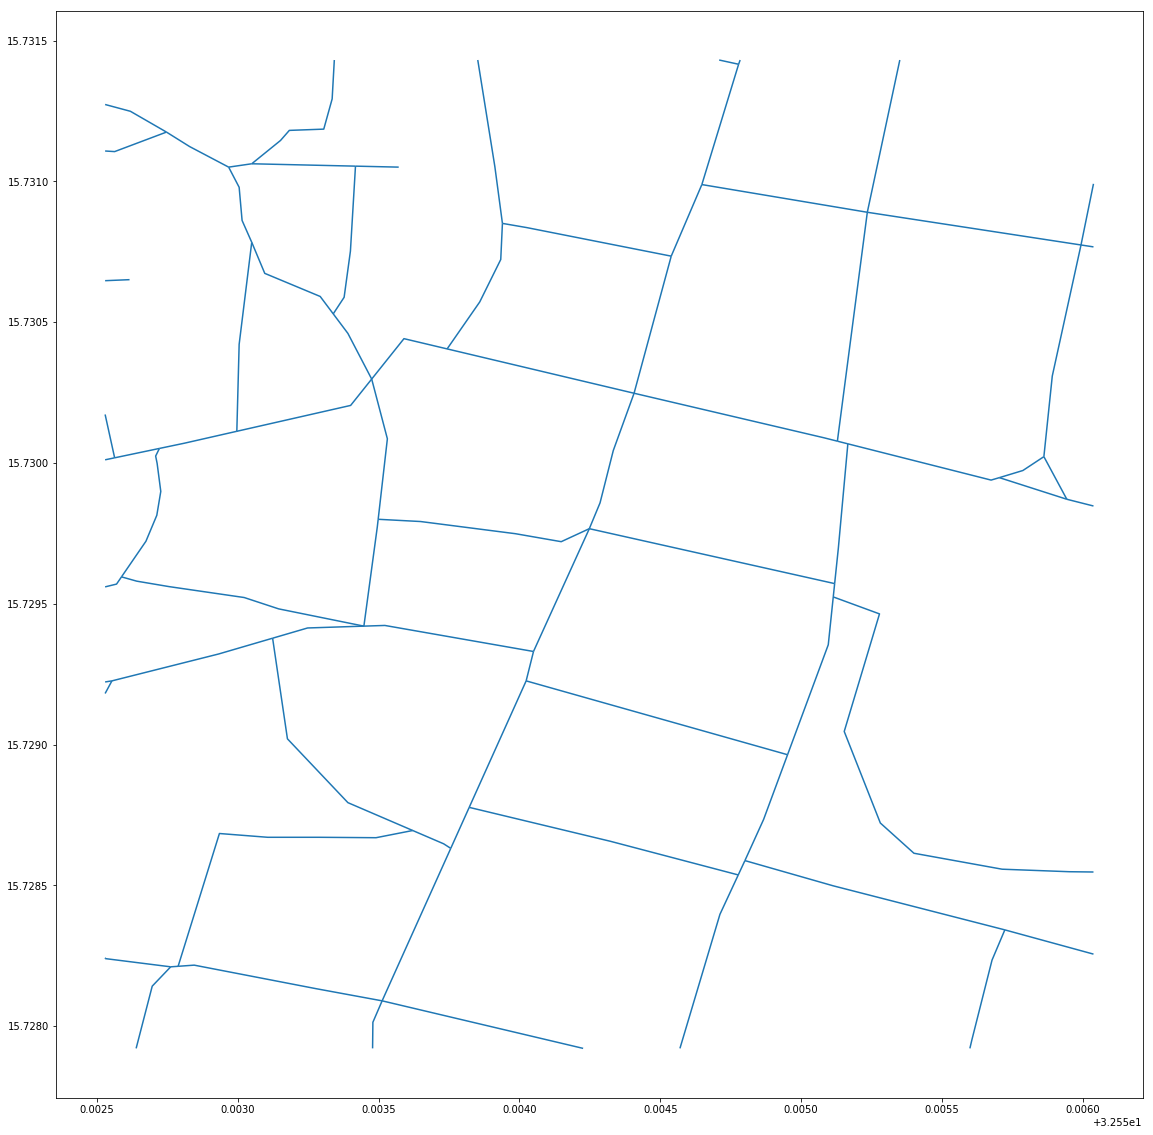

In [83]:
gdf.set_geometry('centroid') #returns a new obj
print(gdf.geometry.name)
gdf.plot(figsize=(20,20))